# Assignment 2: recommender System

## Code from the lecture

In [1]:
#read data to DataFrames
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('../../DATA/movielens100k/u.user', sep='|', names=u_cols, encoding = "ISO-8859-1")

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('../../DATA/movielens100k/u.data', sep='\t', names=r_cols, encoding = "ISO-8859-1")

m_cols=['movie_id', 'title', 'release date', 'video release date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('../../DATA/movielens100k/u.item', sep='|', names=m_cols ,encoding = "ISO-8859-1" )

In [2]:
#gerate matrix (this can be done more efficiently!)
R=np.zeros((np.shape(users)[0],np.shape(movies)[0]))
for i in range(np.shape(ratings)[0]):
    R[ratings['user_id'][i]-1, ratings['movie_id'][i]-1]=ratings['rating'][i]

In [3]:
epsilon=0.0000001 
def CosineDist(a,b):
    return a.dot(b)/(np.linalg.norm(a)*np.linalg.norm(b)+epsilon) #added epsilon for numerical stability: avoiding div by zero -> NaN

In [4]:
%%time
#again, implementation not efficient: better use lamda opperators 
D=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
for i in range(0,np.shape(movies)[0]):
    for j in range(0,np.shape(movies)[0]):
        if i!=j:
            D[i,j]=CosineDist(R[:,i],R[:,j])

Wall time: 2min 39s


In [5]:
def getTopN(movie_id, D, N=5):
    return D[movie_id,:].argsort()[-N:]

def getIDbyName(name):
    if np.size(movies.movie_id[movies.title.str.contains(name)]) > 0:
        m = int(movies.movie_id[movies.title.str.contains(name)][:1]), str(movies.title[movies.title.str.contains(name)][:1])
        return m[0]-1
    else:
        return -1
    
def getNameByID(IDs):
    res=movies.iloc[IDs]
    return res.title

def CII(title, D):
    if getIDbyName(title) > 0:
        print ("recommending movies for: '" + str(getNameByID(getIDbyName(title)))+"'")
        return getNameByID(getTopN(getIDbyName(title),D))[::-1]
    else:
        print ("no movie title containing " + str(title) + "found...")
        
def Score_byID(ID, D, Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = getTopN(ID,D)[::-1]
    res_title = getNameByID(getTopN(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)
    
#compute scores for all test users
def test_Score(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID(e,D_train, R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

## 4.1 Alternative Distance Measures
Implement a different distance measure, e.g. eucledian and compare the ressults.

In [6]:
#4.1 Alternative Distance Measures
def EucledianDist(a,b):
    return np.linalg.norm(a-b)

In [7]:
%%time
#again, implementation not efficient: better use lamda opperators 
D_euc=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
for i in range(0,np.shape(movies)[0]):
    for j in range(0,np.shape(movies)[0]):
        if i!=j:
            D_euc[i,j]=EucledianDist(R[:,i],R[:,j])

Wall time: 1min 25s


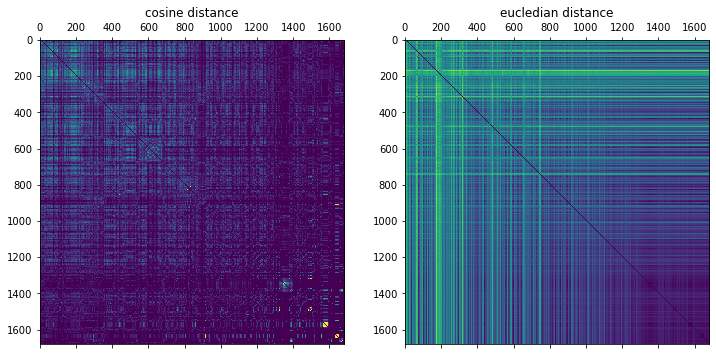

In [8]:
#plot distance  
fig = plt.figure(figsize=(12, 12))

ax1 = fig.add_subplot(1,2,1) 
ax1.title.set_text('cosine distance')
ax1.matshow(D)
ax2 = fig.add_subplot(1,2,2)
ax2.title.set_text('eucledian distance')
ax2.matshow(D_euc) 
    
plt.show()

In [9]:
#Anfrage mit cosine distance
CII("Star",D)

recommending movies for: 'Star Wars (1977)'


180          Return of the Jedi (1983)
173     Raiders of the Lost Ark (1981)
171    Empire Strikes Back, The (1980)
0                     Toy Story (1995)
126              Godfather, The (1972)
Name: title, dtype: object

In [10]:
#Anfrage mit eucledian distance
CII("Star",D_euc)

recommending movies for: 'Star Wars (1977)'


989              Anna Karenina (1997)
1061    Four Days in September (1997)
1126          Truman Show, The (1998)
937        Smile Like Yours, A (1997)
1242               Night Flier (1997)
Name: title, dtype: object

In [11]:
test_res=test_Score(D,R)
test_res_euc=test_Score(D_euc,R)

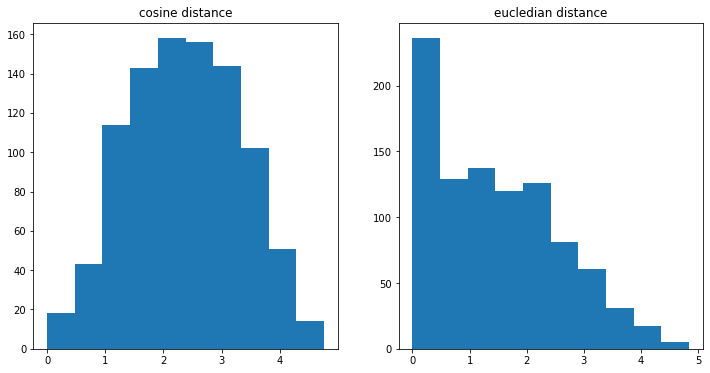

In [12]:
#plot distance  
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(1,2,1) 
ax1.title.set_text('cosine distance')
ax1.hist(test_res);
ax2 = fig.add_subplot(1,2,2)
ax2.title.set_text('eucledian distance')
ax2.hist(test_res_euc) ;

In [13]:
print("mean cosine:", np.mean(test_res), "\nmean eucledian:", np.mean(test_res_euc))

mean cosine: 2.3701802757158004 
mean eucledian: 1.4630328738069989


## 4.2 Baseline Results
Implement and compare results of two very simple baseline methods 
* random recommendations: randomly recommend 5 movies (HINT user np.random sub-library to generate random movie IDs)
* always recommending the top 5 movies: HINT: need to find the IDs of the top 5 movies over all users first

In [32]:
#4.2.a recommend 5 random Movies
def randomMovies():
    randomMovie = np.random.randint(R.shape[1], size=(5))
    return randomMovie

#4.2.b overall top 5 movies
def topFiveMovies(D):
    ranking = np.sum(D,axis=0)
    IDs = np.argpartition(ranking, -5)[-5:]
    return IDs

In [33]:
#Funktion abgeändert für random recommendation
def Score_byID_random(ID, D, Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = randomMovies()
    res_title = getNameByID(getTopN(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)

#compute scores for all test users
def test_Score_random(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID_random(e,D_train, R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

In [34]:
test_radnom = test_Score_random(D,R)

In [35]:
print ("Mean random: ",np.mean(test_radnom))

Mean random:  0.23393425238600216


In [36]:
five_randomMovies = randomMovies()
print (five_randomMovies)
getNameByID(five_randomMovies)

[1660  361  736  919 1090]


1660           New Age, The (1994)
361     Blues Brothers 2000 (1998)
736                  Sirens (1994)
919                Two Bits (1995)
1090          Pete's Dragon (1977)
Name: title, dtype: object

In [37]:
#Funktion abgeändert für Top 5
def Score_byID_top(ID, D, Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = topFiveMovies(D)
    res_title = getNameByID(getTopN(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)

#compute scores for all test users
def test_Score_top(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID_top(e,D_train, R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

In [38]:
test_top = test_Score_top(D,R)

In [39]:
print ("Mean top: ",np.mean(test_top))

Mean top:  1.618239660657476


In [42]:
top_five = topFiveMovies(D)

print (top_five)
getNameByID(top_five)

[ 78  55 203 171 173]


78                Fugitive, The (1993)
55                 Pulp Fiction (1994)
203          Back to the Future (1985)
171    Empire Strikes Back, The (1980)
173     Raiders of the Lost Ark (1981)
Name: title, dtype: object

## 4.3 SVD
Implement the SVD approach. Hints: 
* use numpy.linalg.svd()
* apply SVD on $D$
* plot the singular values and decide where to cut off the reconstruction
* reconstruct and evaluate $D'$


In [50]:
#4.3 Singular Value Decomposition
U,S,V = np.linalg.svd(D)

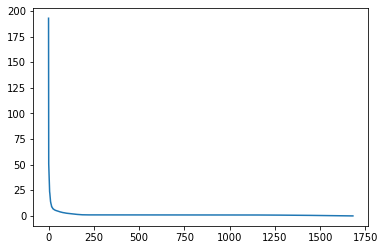

In [52]:
#plot SVD
plt.plot(S);

In [43]:
cut = 30
D_cut = np.dot(U[:,:cut]*S[:cut],V[:cut,:])

In [44]:
test_D=test_Score(D,R)
test_D_cut=test_Score(D_cut,R)

In [46]:
print('mean without cut: ', np.mean(test_D), "\nmean with cut: ", np.mean(test_D_cut))


mean without cut:  2.3701802757158004 
mean with cut:  2.770349946977731
